In [ ]:
#dataset.py
import numpy as np
import glob
import scipy.io as sio
import torch
from torch.utils.data import Dataset, DataLoader


def UT_HAR_dataset(root_dir):
    data_list = glob.glob(root_dir+'/UT_HAR/data/*.csv')
    label_list = glob.glob(root_dir+'/UT_HAR/label/*.csv')
    WiFi_data = {}
    for data_dir in data_list:
        data_name = data_dir.split('/')[-1].split('.')[0]
        with open(data_dir, 'rb') as f:
            data = np.load(f)
            data = data.reshape(len(data),1,250,90)
            data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))
        WiFi_data[data_name] = torch.Tensor(data_norm)
    for label_dir in label_list:
        label_name = label_dir.split('/')[-1].split('.')[0]
        with open(label_dir, 'rb') as f:
            label = np.load(f)
        WiFi_data[label_name] = torch.Tensor(label)
    return WiFi_data

In [ ]:
data= UT_HAR_dataset('/content/drive/MyDrive/Data')
data['y_val'].shape


torch.Size([496])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install einops

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import tensorflow
import h5py


In [ ]:
def train(model_name,model, tensor_loader,  num_epochs, learning_rate, criterion, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        for data in tensor_loader:
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.type(torch.LongTensor)

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            outputs = outputs.type(torch.FloatTensor)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
            predict_y = torch.argmax(outputs,dim=1).to(device)
            epoch_accuracy += (predict_y == labels.to(device)).sum().item() / labels.size(0)
        epoch_loss = epoch_loss/len(tensor_loader.dataset)
        epoch_accuracy = epoch_accuracy/len(tensor_loader)
        print('Epoch:{}, Accuracy:{:.4f},Loss:{:.9f}'.format(epoch+1, float(epoch_accuracy),float(epoch_loss)))

        #creating h5 file
        if model_name=='CNN+GRU':
          torch.save(model.state_dict(), 'UT_HAR_model1.h5')
        elif model_name=='ResNet18':
          torch.save(model.state_dict(), 'UT_HAR_model2.h5')
        elif model_name=='ResNet50':
          torch.save(model.state_dict(), 'UT_HAR_model3.h5')
    return

def test(model, tensor_loader, criterion, device):
    model.eval()
    test_acc = 0
    test_loss = 0
    for data in tensor_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels.to(device)
        labels = labels.type(torch.LongTensor)

        outputs = model(inputs)
        outputs = outputs.type(torch.FloatTensor)
        outputs.to(device)

        loss = criterion(outputs,labels)
        predict_y = torch.argmax(outputs,dim=1).to(device)
        accuracy = (predict_y == labels.to(device)).sum().item() / labels.size(0)
        test_acc += accuracy
        test_loss += loss.item() * inputs.size(0)
    test_acc = test_acc/len(tensor_loader)
    test_loss = test_loss/len(tensor_loader.dataset)
    print("validation accuracy:{:.4f}, loss:{:.5f}".format(float(test_acc),float(test_loss)))
    return


In [ ]:
class UT_HAR_LeNet(nn.Module):
    def __init__(self):
        super(UT_HAR_LeNet,self).__init__()
        self.encoder = nn.Sequential(
            #input size: (1,250,90)
            nn.Conv2d(1,32,7,stride=(3,1)),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,(5,4),stride=(2,2),padding=(1,0)),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64,96,(3,3),stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(96*4*4,128),
            nn.ReLU(),
            nn.Linear(128,7)
        )

    def forward(self,x):
        x = self.encoder(x)
        x = x.view(-1,96*4*4)
        out = self.fc(x)
        return out


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.conv3(x)
        x = self.batch_norm3(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = self.relu(x)
        return x


class UT_HAR_ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes=7):
        super(UT_HAR_ResNet, self).__init__()
        self.reshape = nn.Sequential(
            nn.Conv2d(1,3,7,stride=(3,1)),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(3,3,kernel_size=(10,11),stride=1),
            nn.ReLU()
        )
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.reshape(x)
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

def UT_HAR_ResNet50():
  return UT_HAR_ResNet(Bottleneck, [3,4,6,3])







In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
class UT_HAR_LSTM(nn.Module):
    def __init__(self,hidden_dim=64):
        super(UT_HAR_LSTM,self).__init__()
        self.lstm = nn.LSTM(90,hidden_dim,num_layers=1)
        self.fc = nn.Linear(hidden_dim,7)
    def forward(self,x):
        x = x.view(-1,250,90)
        x = x.permute(1,0,2)
        _, (ht,ct) = self.lstm(x)
        outputs = self.fc(ht[-1])
        return outputs



In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.conv3(x)
        x = self.batch_norm3(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = self.relu(x)
        return x


class UT_HAR_ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes=7):
        super(UT_HAR_ResNet, self).__init__()
        self.reshape = nn.Sequential(
            nn.Conv2d(1,3,7,stride=(3,1)),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(3,3,kernel_size=(10,11),stride=1),
            nn.ReLU()
        )
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.reshape(x)
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

def UT_HAR_ResNet18():
  return UT_HAR_ResNet(Block, [2,2,2,2])






In [ ]:
import numpy as np
import torch
import torch.nn as nn
import argparse
from sklearn.ensemble import VotingClassifier
root = '/content/drive/MyDrive/Data'
data = UT_HAR_dataset(root)
train_set = torch.utils.data.TensorDataset(data['X_train'],data['y_train'])
test_set = torch.utils.data.TensorDataset(torch.cat((data['X_val'],data['X_test']),0),torch.cat((data['y_val'],data['y_test']),0))
X_test = torch.cat((data['X_val'],data['X_test']),0)
Y_test= torch.cat((data['y_val'],data['y_test']),0)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True, drop_last=True) # drop_last=True
test_loader = torch.utils.data.DataLoader(test_set,batch_size=256,shuffle=False)

model= UT_HAR_LeNet()
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train(
      model_name= 'CNN',
      model= model,
      tensor_loader= train_loader,
      num_epochs= 15,
      learning_rate=1e-3,
      criterion=criterion,
      device=device
         )
test(
      model= model,
      tensor_loader=test_loader,
      criterion=criterion,
      device= device
        )


Epoch:1, Accuracy:0.2828,Loss:1.813389267
Epoch:2, Accuracy:0.3090,Loss:1.760836313
Epoch:3, Accuracy:0.4128,Loss:1.532172526
Epoch:4, Accuracy:0.5189,Loss:1.257570086
Epoch:5, Accuracy:0.6227,Loss:1.045732132
Epoch:6, Accuracy:0.6752,Loss:0.903623477
Epoch:7, Accuracy:0.7193,Loss:0.781103185
Epoch:8, Accuracy:0.7462,Loss:0.702980356
Epoch:9, Accuracy:0.7901,Loss:0.600105675
Epoch:10, Accuracy:0.8158,Loss:0.519264566
Epoch:11, Accuracy:0.8417,Loss:0.460769978
Epoch:12, Accuracy:0.8904,Loss:0.333475951
Epoch:13, Accuracy:0.8947,Loss:0.312476070
Epoch:14, Accuracy:0.9070,Loss:0.276911257
Epoch:15, Accuracy:0.9282,Loss:0.220021826
validation accuracy:0.9183, loss:0.24568


In [ ]:
 model.load_state_dict(torch.load('UT_HAR_model1.h5'))
 model.eval()



FileNotFoundError: [Errno 2] No such file or directory: 'UT_HAR_model1.h5'

In [ ]:
with torch.no_grad():
    predictions = np.argmax(model(data['X_test']),axis=-1)

In [ ]:
data['y_test'].shape


torch.Size([500])

In [ ]:
predictions.shape

torch.Size([500])

[[ 55   0   0   3   0   4   4]
 [  0  43   1   0   1   0   0]
 [  1   0 140   0   4   0   2]
 [  1   0   0  49   0   0   0]
 [  0   0   0   4 116   1   0]
 [  2   2   1   0   0  31   4]
 [  3   0   1   0   1   1  25]]
classification_report of model1:
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        66
         1.0       0.96      0.96      0.96        45
         2.0       0.98      0.95      0.97       147
         3.0       0.88      0.98      0.92        50
         4.0       0.95      0.96      0.95       121
         5.0       0.84      0.78      0.81        40
         6.0       0.71      0.81      0.76        31

    accuracy                           0.92       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.92      0.92      0.92       500



<Axes: >

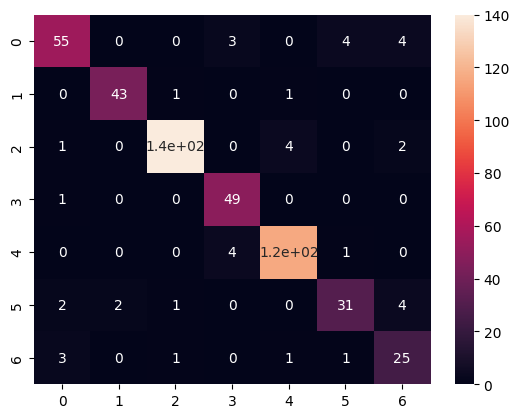

In [ ]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm= confusion_matrix(data['y_test'],predictions)
print(cm)
print("classification_report of model1:")
print(classification_report(data['y_test'],predictions))
sns.heatmap(cm, annot=True)

In [ ]:
num_classes = cm.shape[0]

# Initialize arrays to store TPR and FPR for each class
tpr_per_class = dict()
fpr_per_class = dict()

for i in range(num_classes):
    # True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN) for each class
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    # Calculate TPR and FPR for each class
    tpr_per_class[i] = TP / (TP + FN)
    fpr_per_class[i] = FP / (FP + TN)

# Print TPR and FPR for each class
for i in range(num_classes):
    print(f"Class {i} - TPR: {tpr_per_class[i]:.4f}, FPR: {fpr_per_class[i]:.4f}")


Class 0 - TPR: 0.8333, FPR: 0.0161
Class 1 - TPR: 0.9556, FPR: 0.0044
Class 2 - TPR: 0.9524, FPR: 0.0085
Class 3 - TPR: 0.9800, FPR: 0.0156
Class 4 - TPR: 0.9587, FPR: 0.0158
Class 5 - TPR: 0.7750, FPR: 0.0130
Class 6 - TPR: 0.8065, FPR: 0.0213


In [ ]:
Y_test_flat = data['y_test'].view(data['y_test'].size(0), -1)

In [ ]:
from sklearn.preprocessing import label_binarize
Y_test_bin = label_binarize(Y_test_flat, classes= [0,1,2,3,4,5,6])

In [ ]:
Y_test_bin.shape

(500, 7)

In [ ]:
predictions_flat= predictions.view(predictions.size(0), -1)

In [ ]:
predictions_flat.shape

torch.Size([500, 1])

In [ ]:
pred_bin=label_binarize(predictions_flat, classes= [0,1,2,3,4,5,6])

In [ ]:
pred_bin.shape

(500, 7)

In [ ]:
type(pred_bin)

numpy.ndarray

In [ ]:
from __future__ import division
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from sklearn.metrics import auc, roc_curve
import matplotlib
from sklearn.naive_bayes import GaussianNB

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming Y_test_bin and pred_bin are NumPy arrays (not tensors)
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_bin[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

print(roc_auc_per_class)

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_per_class[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')  # Clearer label
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()








In [ ]:
model= UT_HAR_ResNet50()
model.to(device)

train(
      model_name= 'ResNet50',
      model=model,
      tensor_loader= train_loader,
      num_epochs= 25,
      learning_rate=1e-3,
      criterion=criterion,
      device=device
         )
test(
      model=model,
      tensor_loader=test_loader,
      criterion=criterion,
      device= device
        )


In [ ]:
 model.load_state_dict(torch.load('UT_HAR_model3.h5'))
 model.eval()
 with torch.no_grad():
    predictions = np.argmax(model(data['X_test']),axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm= confusion_matrix(data['y_test'],predictions)
print(cm)
print("classification_report of model1:")
print(classification_report(data['y_test'],predictions))
sns.heatmap(cm, annot=True)

In [ ]:
num_classes = cm.shape[0]

# Initialize arrays to store TPR and FPR for each class
tpr_per_class = np.zeros(num_classes)
fpr_per_class = np.zeros(num_classes)

for i in range(num_classes):
    # True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN) for each class
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    # Calculate TPR and FPR for each class
    tpr_per_class[i] = TP / (TP + FN)
    fpr_per_class[i] = FP / (FP + TN)

# Print TPR and FPR for each class
for i in range(num_classes):
    print(f"Class {i} - TPR: {tpr_per_class[i]:.4f}, FPR: {fpr_per_class[i]:.4f}")

In [ ]:
Y_test_flat = data['y_test'].view(data['y_test'].size(0), -1)
Y_test_bin = label_binarize(Y_test_flat, classes= [0,1,2,3,4,5,6])
Y_test_bin.shape

In [ ]:
predictions_flat= predictions.view(predictions.size(0), -1)
pred_bin=label_binarize(predictions_flat, classes= [0,1,2,3,4,5,6])
pred_bin.shape


In [ ]:
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_bin[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])


# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(7):
  plt.plot(fpr[i], tpr[i],label=f'Class {i} (AUC = {roc_auc_per_class[i]:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model= UT_HAR_ResNet18()
model.to(device)

train(
      model_name= 'ResNet18',
      model=model,
      tensor_loader= train_loader,
      num_epochs= 50,
      learning_rate=1e-3,
      criterion=criterion,
      device=device
         )
test(
      model=model,
      tensor_loader=test_loader,
      criterion=criterion,
      device= device
        )

In [ ]:
model.load_state_dict(torch.load('UT_HAR_model2.h5'))
model.eval()
with torch.no_grad():
  predictions = np.argmax(model(data['X_test']),axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm= confusion_matrix(data['y_test'],predictions)
print(cm)
print("classification_report of model1:")
print(classification_report(data['y_test'],predictions))
sns.heatmap(cm, annot=True)

In [ ]:
num_classes = cm.shape[0]

# Initialize arrays to store TPR and FPR for each class
tpr_per_class = np.zeros(num_classes)
fpr_per_class = np.zeros(num_classes)

for i in range(num_classes):
    # True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN) for each class
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    # Calculate TPR and FPR for each class
    tpr_per_class[i] = TP / (TP + FN)
    fpr_per_class[i] = FP / (FP + TN)

# Print TPR and FPR for each class
for i in range(num_classes):
    print(f"Class {i} - TPR: {tpr_per_class[i]:.4f}, FPR: {fpr_per_class[i]:.4f}")

In [ ]:
Y_test_flat = data['y_test'].view(data['y_test'].size(0), -1)
Y_test_bin = label_binarize(Y_test_flat, classes= [0,1,2,3,4,5,6])
Y_test_bin.shape

In [ ]:
predictions_flat= predictions.view(predictions.size(0), -1)
pred_bin=label_binarize(predictions_flat, classes= [0,1,2,3,4,5,6])
pred_bin.shape

In [ ]:
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_bin[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])


# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(7):
  plt.plot(fpr[i], tpr[i],label=f'Class {i} (AUC = {roc_auc_per_class[i]:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()